In [40]:
import findspark
findspark.init()

In [42]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("NewsGroups").getOrCreate()

In [43]:
df = spark.read.text("hdfs://localhost:9000/data/mini_newsgroups/*/*")
from pyspark.sql.functions import input_file_name, regexp_extract
df = df.withColumn("filename", input_file_name())
df = df.withColumn("newsgroup", regexp_extract("filename", r"mini_newsgroups/([^/]+)", 1))
df = df.select("filename", "value", "newsgroup").withColumnRenamed("value", "text")

In [44]:
from pyspark.sql.functions import explode, split, lower, col

In [45]:
stopwords_path = "D:/code/python/BigDataDevelopment/Lesson03/data/Stopwordlist.txt"
with open(stopwords_path, 'r', encoding='utf-8') as f:
    stopwords = [line.strip() for line in f]

In [46]:
words_df = df.select("newsgroup", explode(split(lower(col("text")), "\\s+")).alias("word"))
words_df = words_df.filter(col("word") != "")
words_df = words_df.filter(~col("word").isin(stopwords))

In [50]:
word_count = words_df.groupBy("newsgroup", "word").count()
newsgroups = [row.newsgroup for row in df.select("newsgroup").distinct().collect()]

In [53]:
newsgroups

['comp.windows.x',
 'rec.sport.hockey',
 'comp.os.ms-windows.misc',
 'talk.politics.misc',
 'comp.graphics',
 'soc.religion.christian',
 'talk.religion.misc',
 'talk.politics.mideast',
 'alt.atheism',
 'sci.electronics',
 'sci.space',
 'sci.med',
 'sci.crypt',
 'misc.forsale',
 'rec.sport.baseball',
 'talk.politics.guns',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'rec.autos',
 'rec.motorcycles']

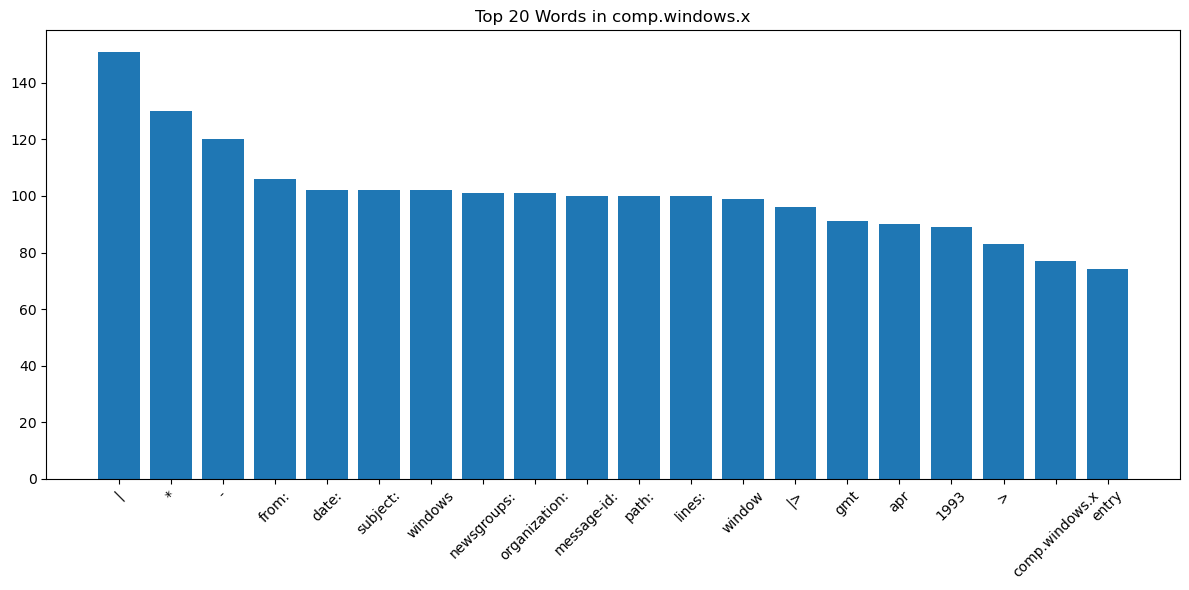

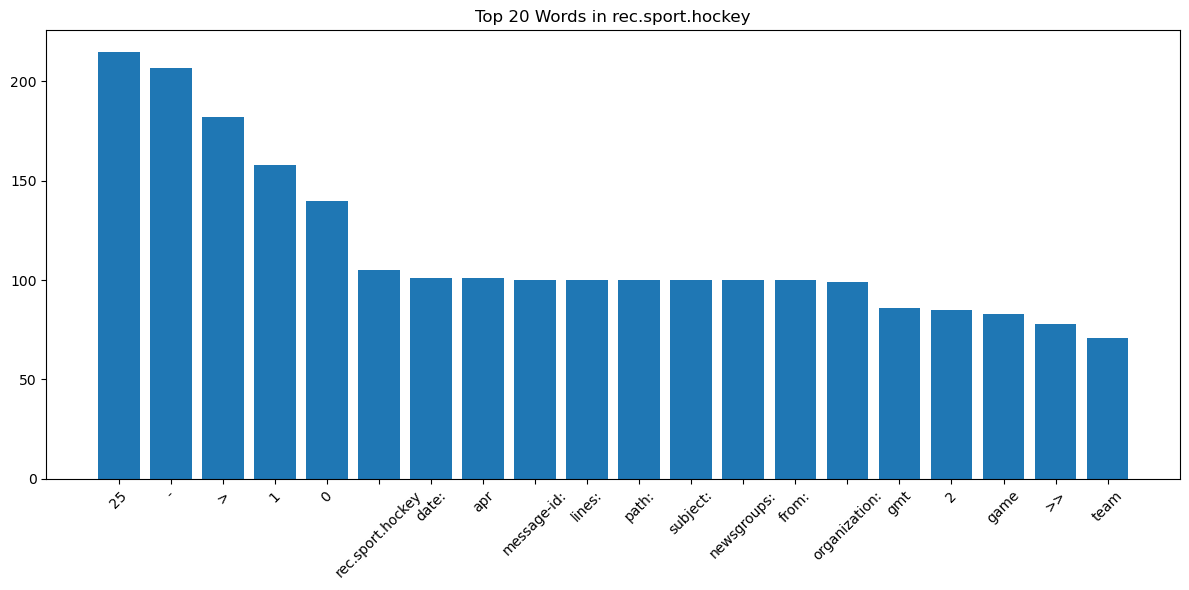

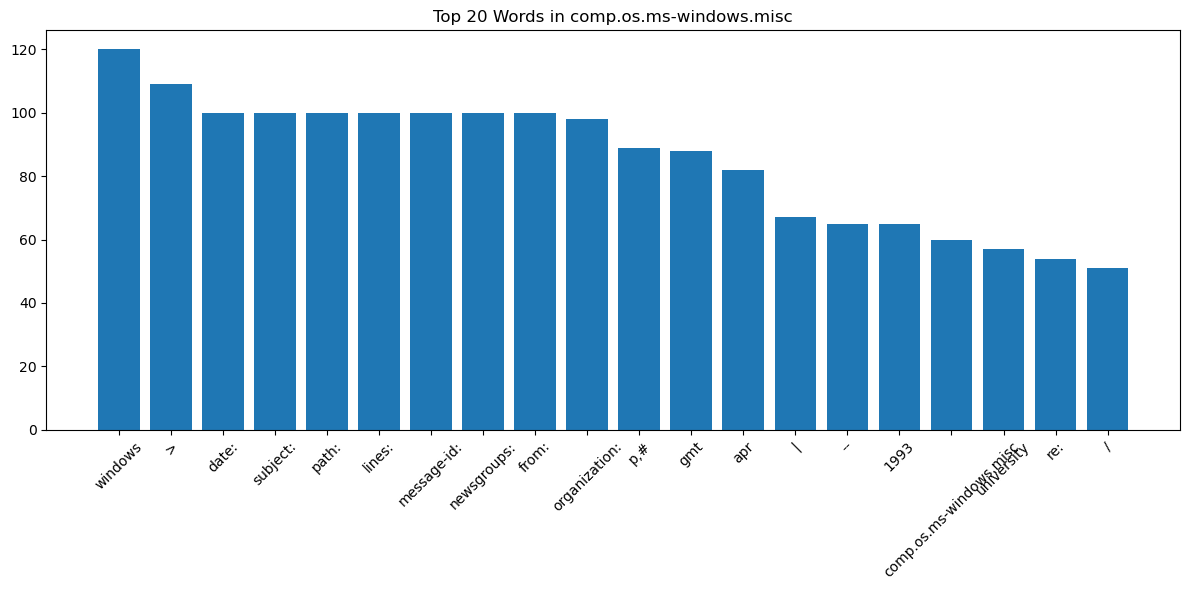

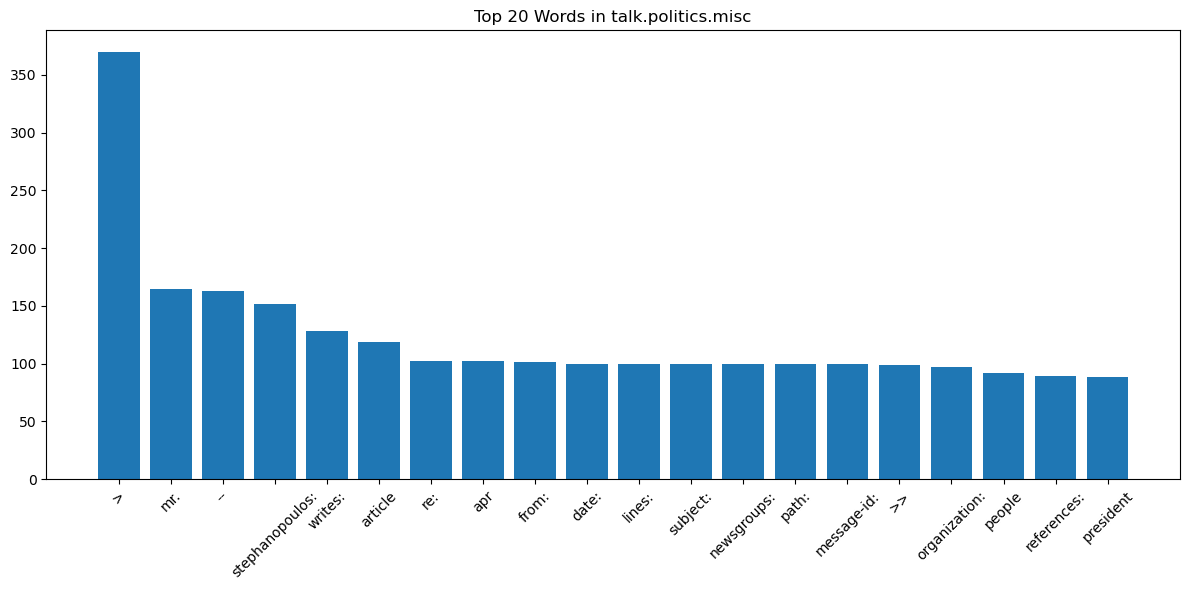

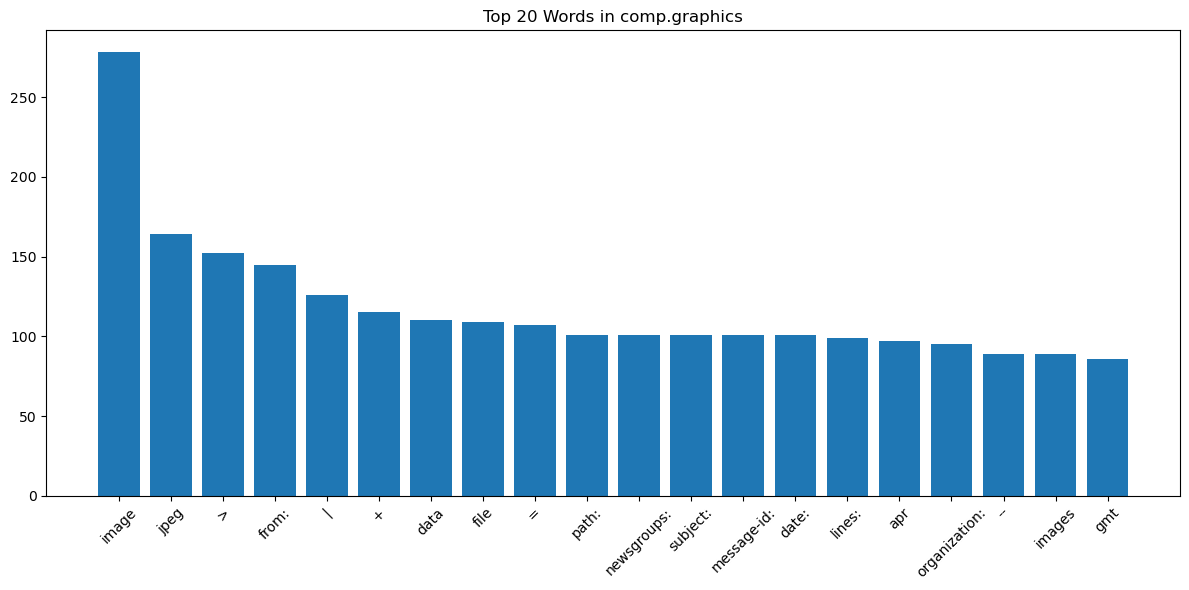

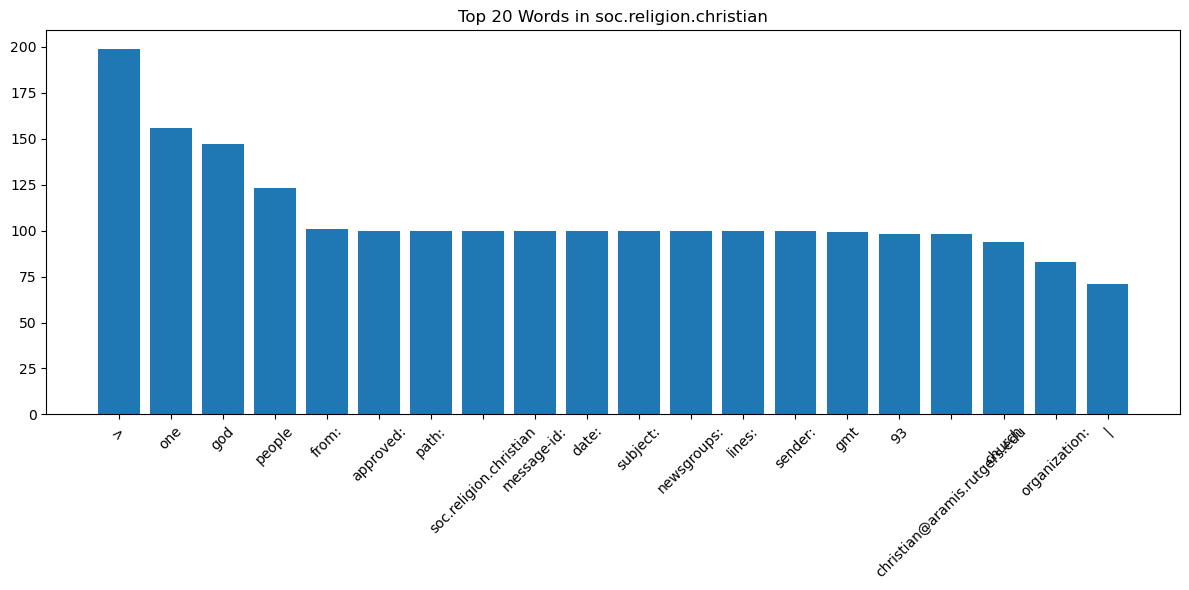

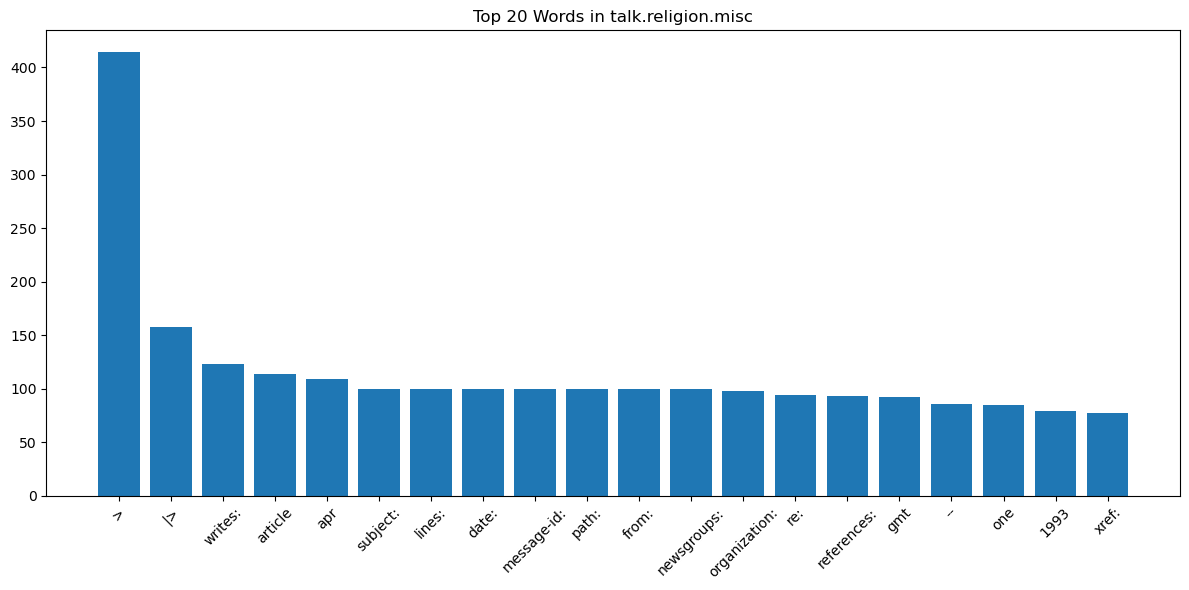

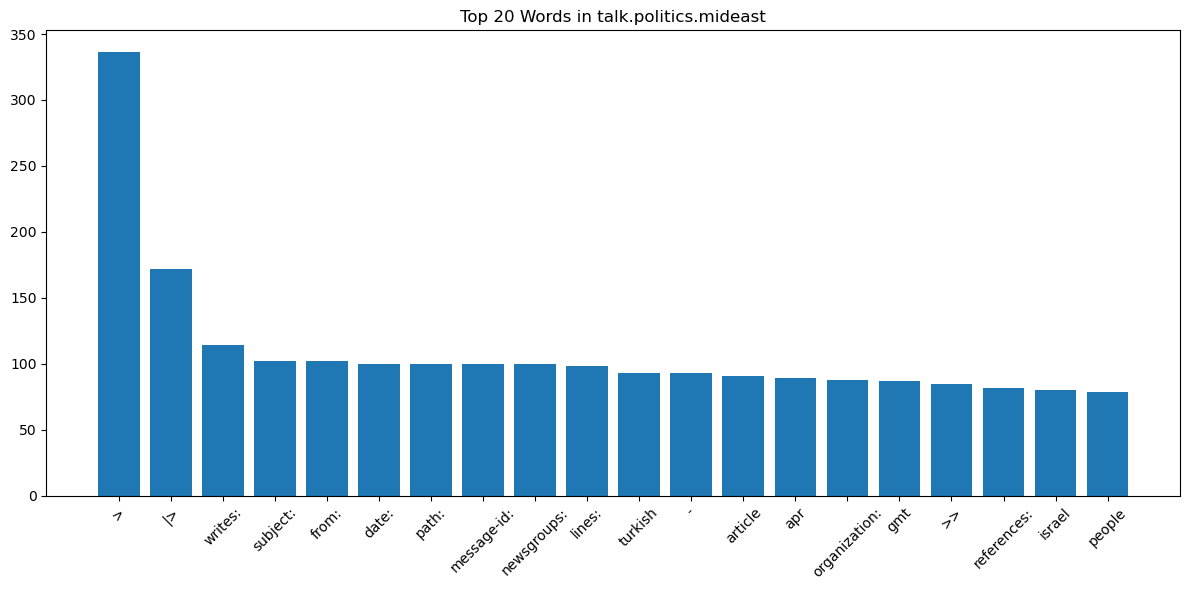

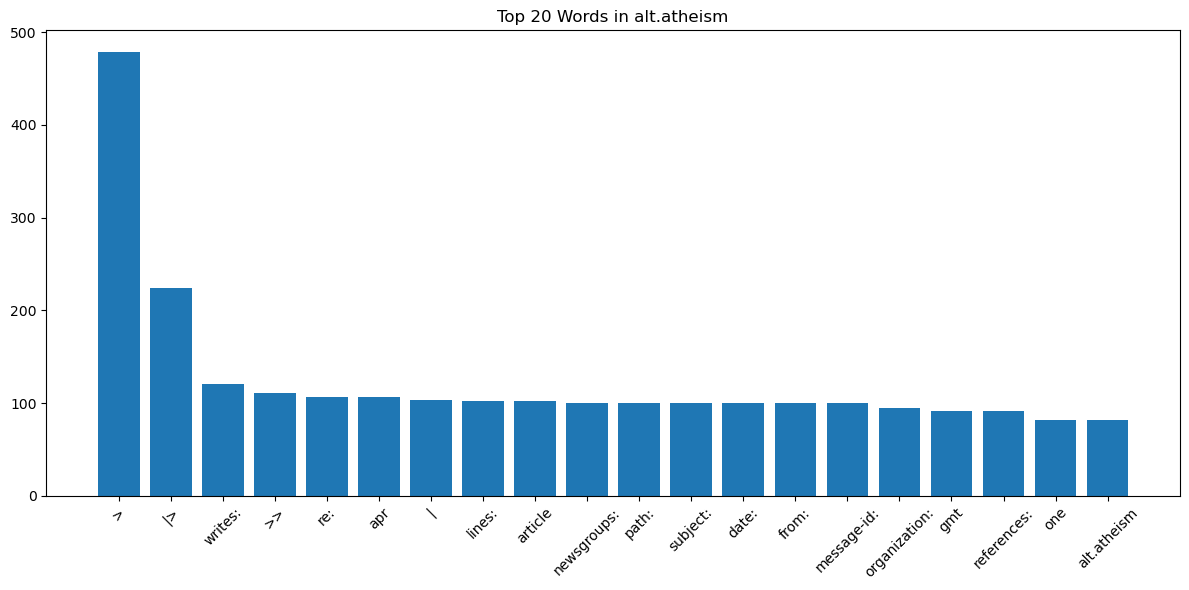

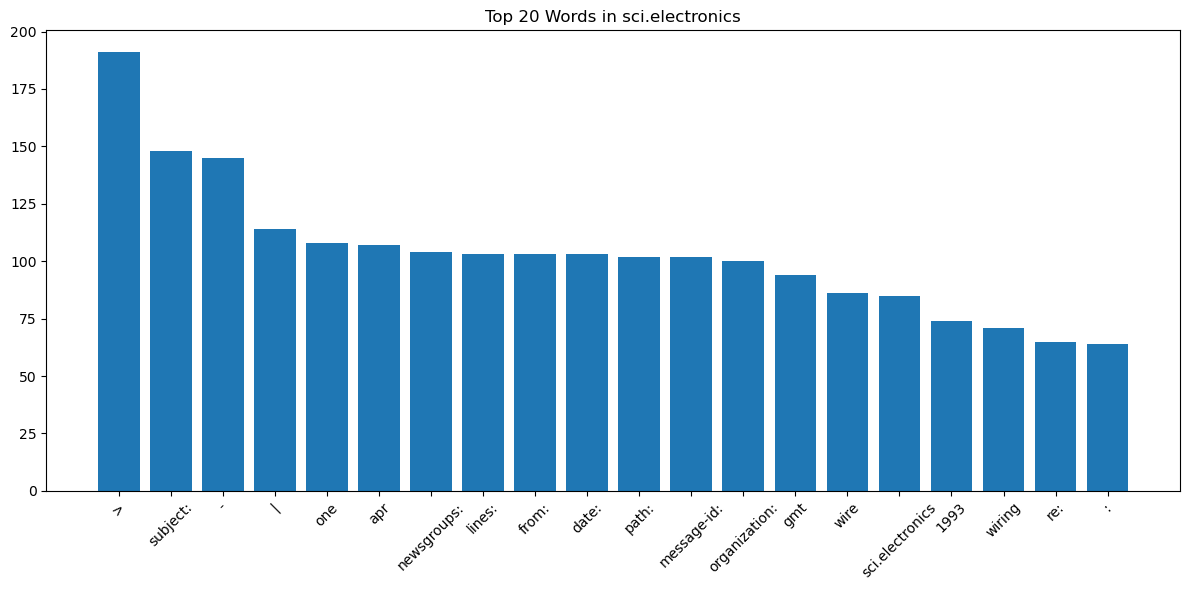

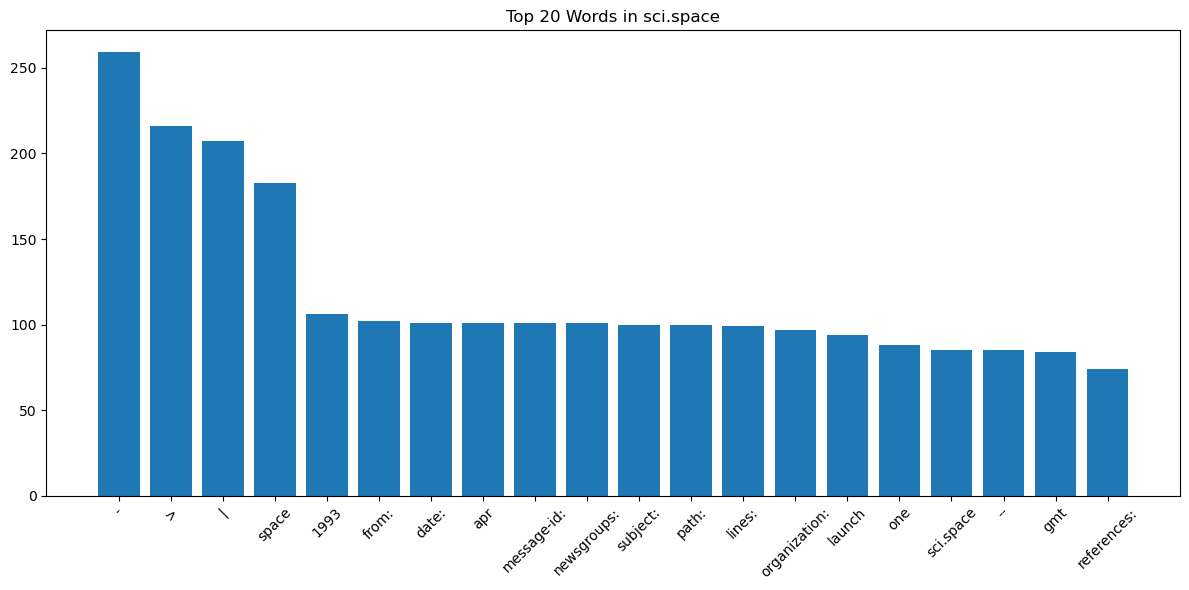

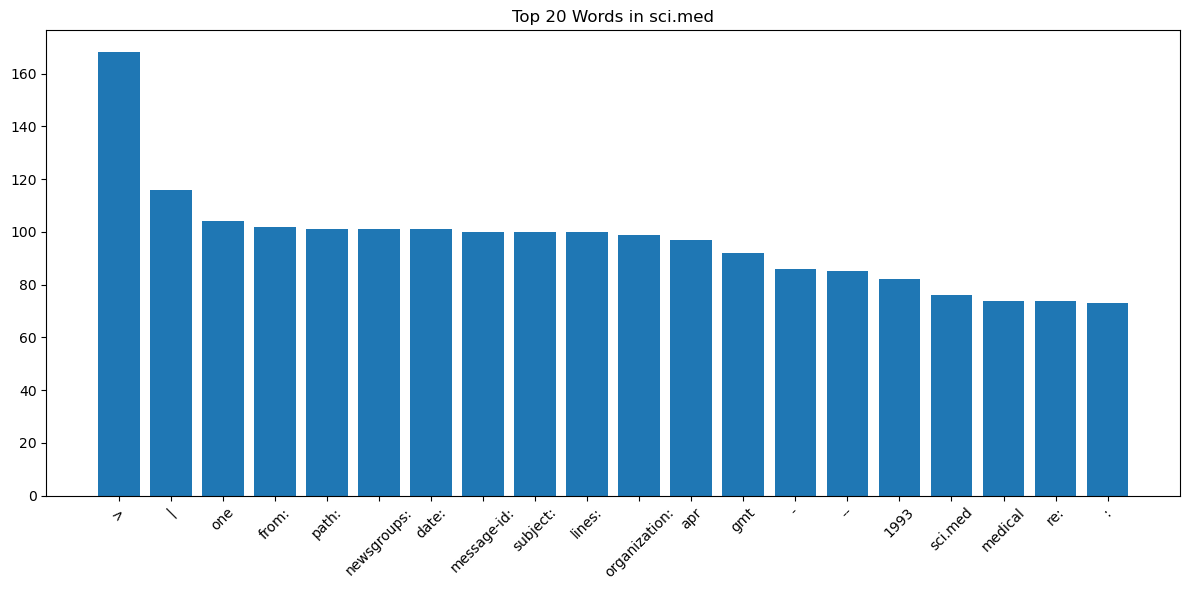

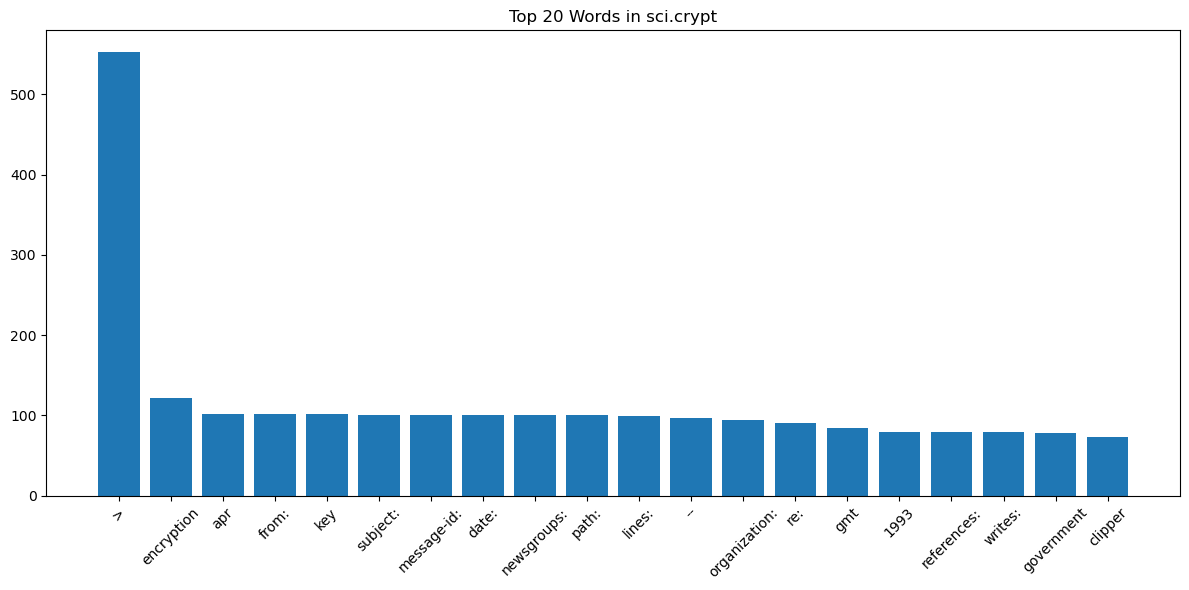

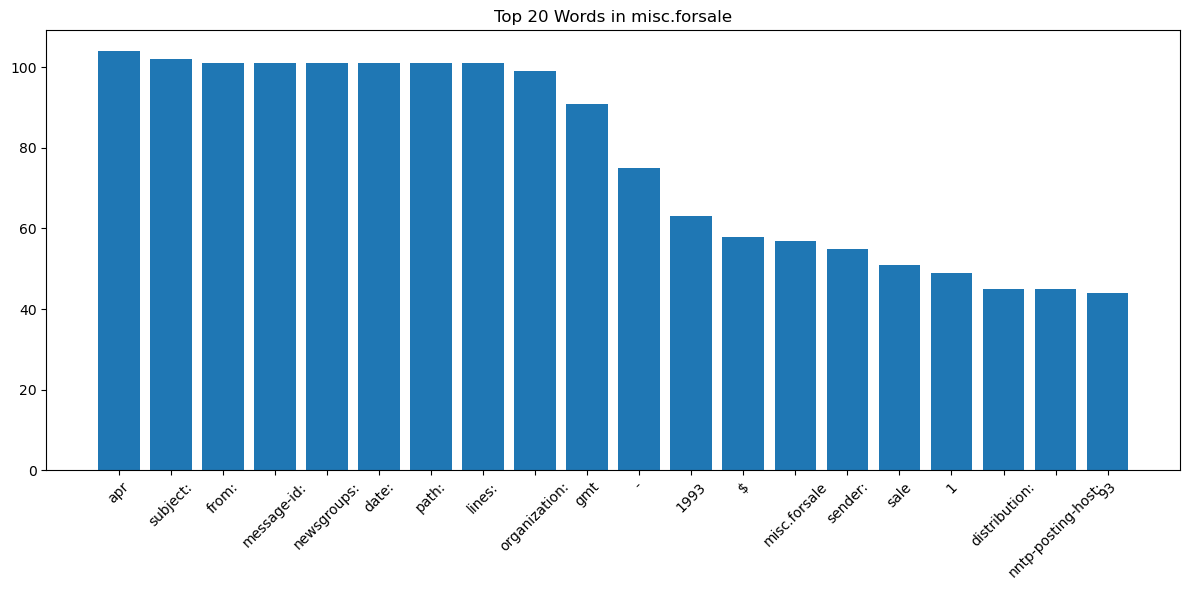

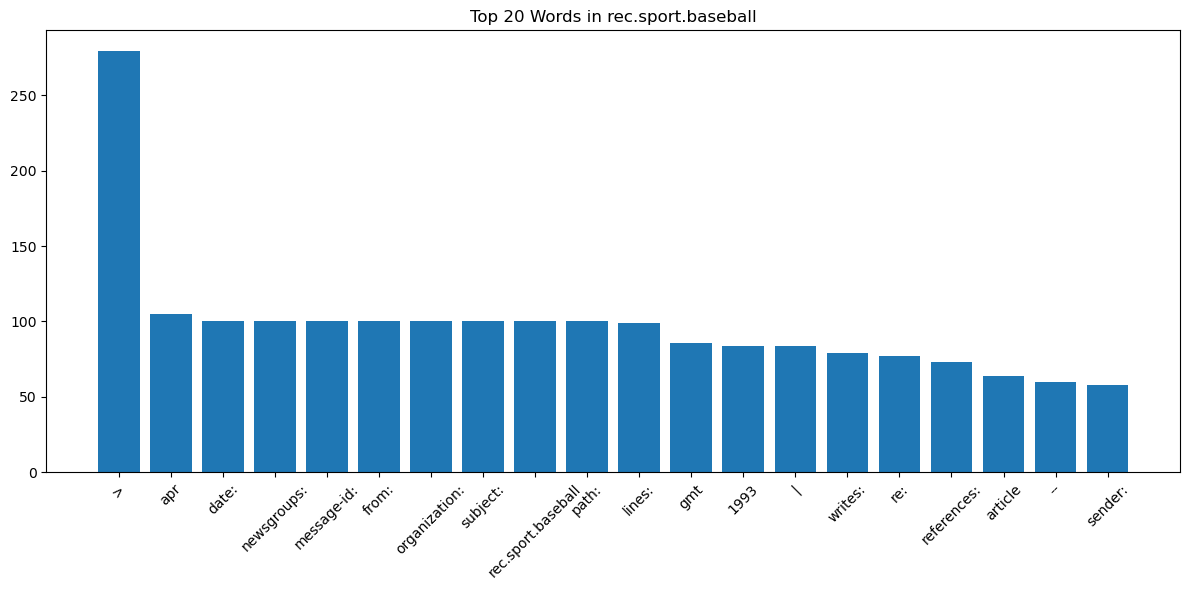

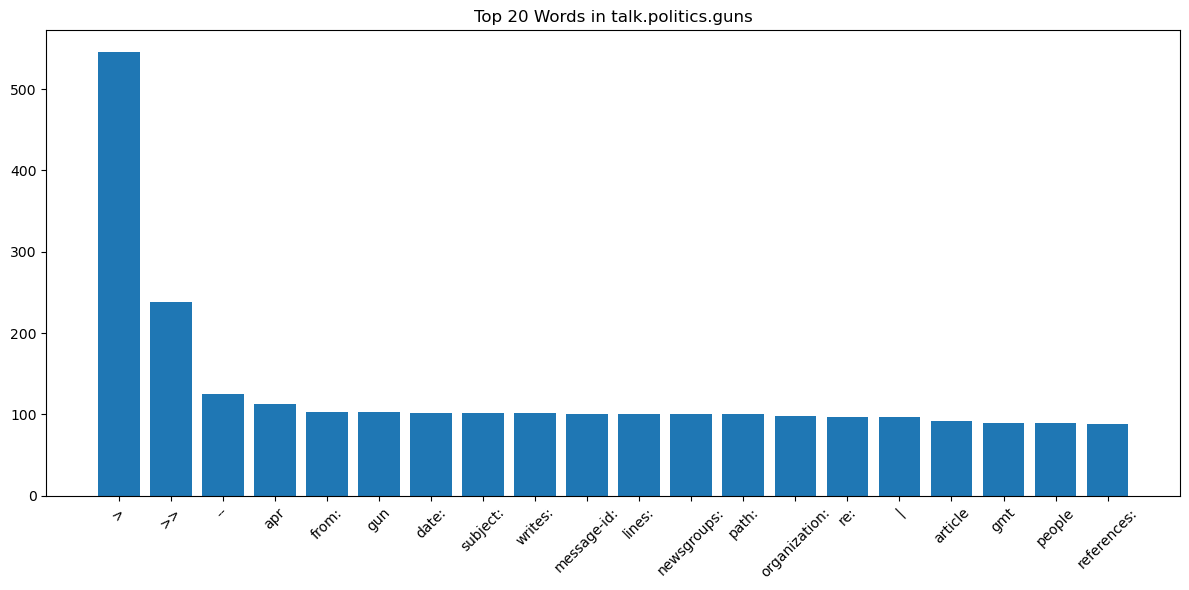

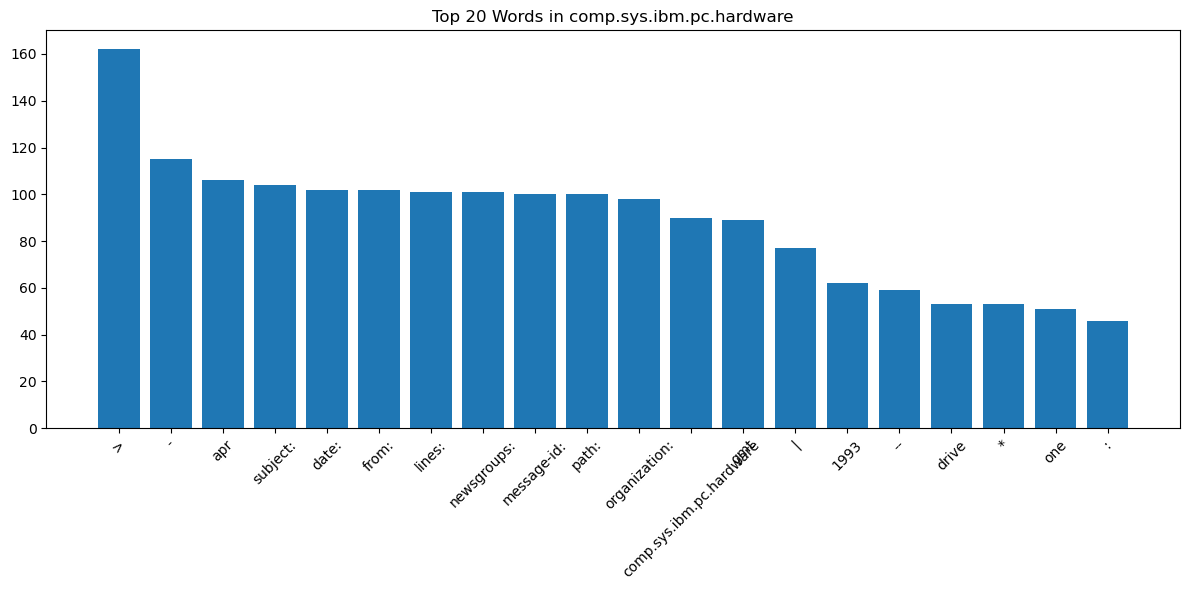

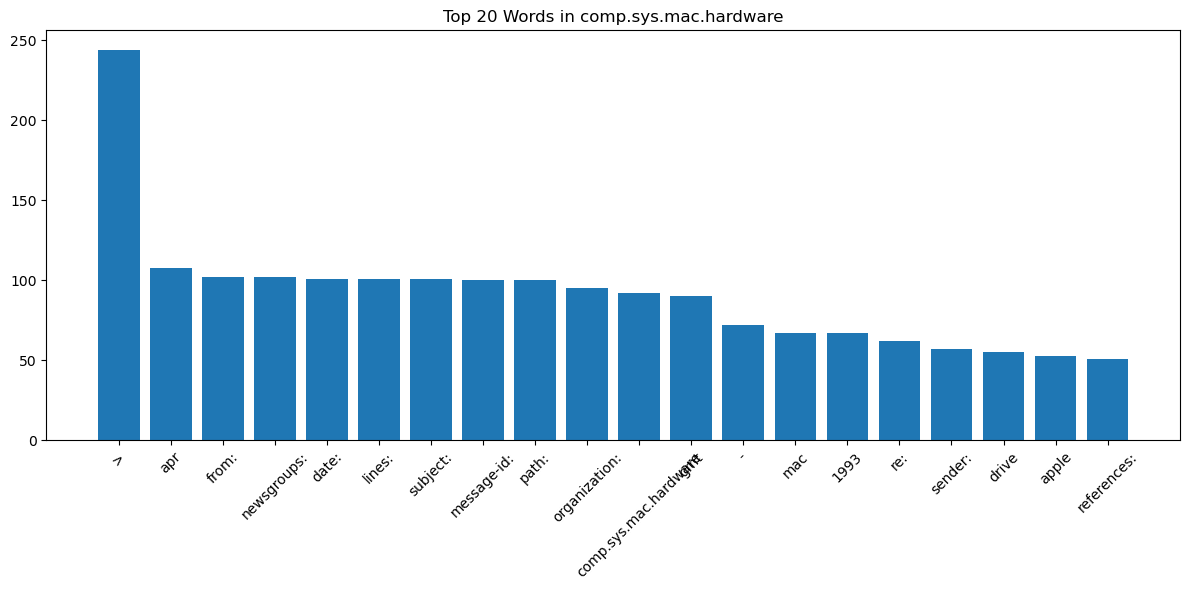

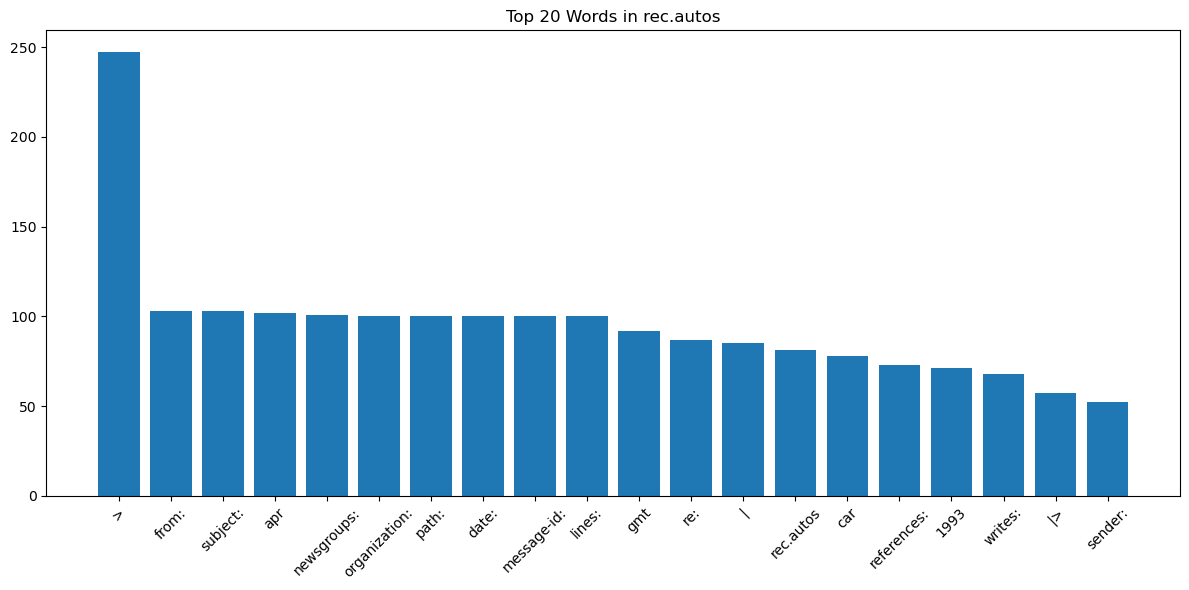

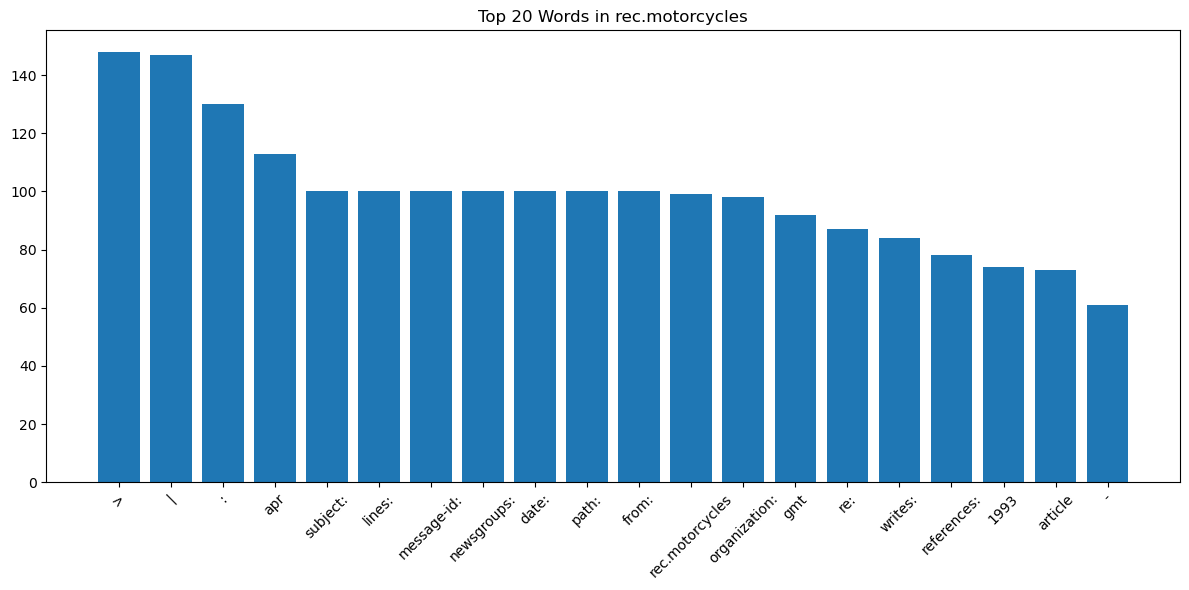

In [54]:
import matplotlib.pyplot as plt

for newsgroup in newsgroups:
    group_words = word_count.filter(col("newsgroup") == newsgroup).orderBy(col("count").desc()).limit(20).toPandas()
    plt.figure(figsize=(12, 6))
    plt.bar(group_words['word'], group_words['count'])
    plt.title(f"Top 20 Words in {newsgroup}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [55]:
spark.stop()